[dummy reg official doc](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)

# library

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import FinanceDataReader as fdr

import datetime as dt

import numpy as np

from tqdm import tqdm #진행바
from tqdm.notebook import tqdm


#시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(mpl.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))


#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')



import warnings
warnings.filterwarnings('ignore')

# GPU
import tensorflow as tf

#https://www.tensorflow.org/guide/gpu#allowing_gpu_memory_growth
#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
#지정해서 쓰고 싶으면 model 쓸 때는 with 구문 안에 넣기

matplotlib version: 3.4.2
seaborn version: 0.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [18]:
# df[['Next_Change']].shape
# df.iloc[:,-1].shape

(2537, 1)

(2537,)

In [15]:
# data load
df = pd.read_csv('stock_2018_10days.csv')

# data split X, y
df_X = df.iloc[:,2:-1]
df_y = df.iloc[:,-1]

# train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.2, random_state = 0) # default option ~ shuffle = True, shuffle; random

# reshape
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)
# y_test.shape

(508, 1)

In [16]:
# 전처리 파이프라인 만들기 #------------------------수치형 데이터 전처리 (scaling) 위한 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

my_pipeline = Pipeline([('mean_imputer', SimpleImputer(strategy = 'mean')),
                       ('mm_scaler', MinMaxScaler())])

# scaling
X_train_fit = my_pipeline.fit(X_train)
X_train_pre = X_train_fit.transform(X_train)
X_test_pre = X_train_fit.transform(X_test)
# print(pd.DataFrame(X_train_pre).describe()) # 전처리 상황 확인

y_train_fit = my_pipeline.fit(y_train)
y_train_pre = y_train_fit.transform(y_train)
y_test_pre = y_train_fit.transform(y_test)

In [5]:
# 회귀 모델 만들기
def my_regressor(df_X, df_y):
    from sklearn.linear_model import LinearRegression # 일반 회귀 모델
    from sklearn.linear_model import Ridge, Lasso, ElasticNet # Norm 규제 회귀 모델
    from sklearn.linear_model import ARDRegression, BayesianRidge # 베이지안 회귀
    from sklearn.ensemble import RandomForestRegressor # decision tree 앙상블 모델, 배깅
    from xgboost import XGBRegressor # decision tree 앙상블 모델, 부스팅
    from sklearn.model_selection import cross_val_score # model 검증
    
    import ast # convert string to function
    import numpy as np
    
    linear = LinearRegression()
    ridge, lasso, elasticnet = Ridge(), Lasso(), ElasticNet()
    ardr_linear, baysian_ridge = ARDRegression(), BayesianRidge()
    random_forest = RandomForestRegressor()
    xgboost_linear = XGBRegressor()
    
    my_model_list = ['linear', 'ridge', 'lasso', 'elasticnet',
                     'ardr_linear', 'baysian_ridge',
                     'random_forest', 'xgboost_linear']

    score_dic = dict()
    for model_nm in tqdm(my_model_list):
        scores = cross_val_score(eval(model_nm), df_X, df_y, scoring = 'neg_mean_squared_error') # 함수의 매개변수로서의 df_X, df_y, # cv default = 5, neg_~가 mse임.
        rmse_score = np.sqrt(-scores)
        rmse_sm = rmse_score.mean()
        score_dic[model_nm] = rmse_sm
    
    score_dic = sorted(score_dic.items(), key = lambda t : t[1]) # mse (작은)순으로 줄세워짐.
    
    return score_dic#[0]

In [13]:
%%time
linear_model_test_score = my_regressor(X_test_pre, y_test_pre)
print(linear_model_test_score)

  0%|          | 0/8 [00:00<?, ?it/s]

[('lasso', 0.09187967935940036), ('elasticnet', 0.09187967935940036), ('baysian_ridge', 0.09225320483574177), ('random_forest', 0.09982928483652416), ('ridge', 0.1035802593310798), ('xgboost_linear', 0.10931487065525287), ('ardr_linear', 0.12047486068319327), ('linear', 0.606424537624551)]
CPU times: user 3h 38min 42s, sys: 1h 26min 56s, total: 5h 5min 39s
Wall time: 5min 3s


In [14]:
dic = {}
for i in linear_model_test_score:
    dic[i[0]] = i[1]

In [15]:
df = pd.DataFrame(dic.items(), columns=['key', 'value'])

In [16]:
df

,key,value
0,lasso,0.091880
1,elasticnet,0.091880
2,baysian_ridge,0.092253
3,random_forest,0.099829
4,ridge,0.103580
5,xgboost_linear,0.109315
6,ardr_linear,0.120475
7,linear,0.606425


# MSE plot

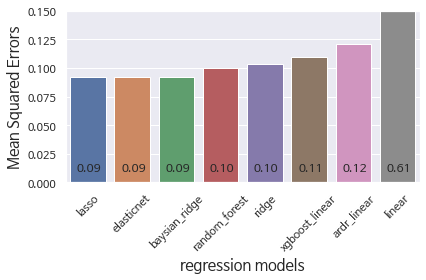

In [47]:
g = sns.barplot(x = 'key', y = 'value', data=df, capsize=.2)
_ = g.set_xticks(range(8))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=45)
_ = g.set_xlabel("regression models", fontsize = 15)
_ = g.set_ylabel("Mean Squared Errors", fontsize = 15)
_ = g.set_ylim([0, 0.15]) # ax.set(ylim=(0.4, 0.6))

val = df['value']
cnt = 0
for i in range(8):
    _ = g.text(cnt-0.25, 0.01, f'{val[i]:.2f}')
    cnt += 1

plt.tight_layout()
# bar plot official doc
# https://seaborn.pydata.org/generated/seaborn.barplot.html
# .set_xticklabels rot
# https://data-newbie.tistory.com/261
# .set_label
# https://www.delftstack.com/ko/howto/seaborn/seaborn-lineplot/

# Dummy test
[새로운 dummy regressor](https://dlsdn73.tistory.com/820)

In [25]:
from sklearn.dummy import DummyRegressor
from sklearn import metrics

# X_train_pre
# X_test_pre
# y_train_pre
# y_test_pre

# 더미 회귀 모델을 만든다. # 알고리즘 선언
dummy = DummyRegressor(strategy = 'mean')

##새로운 방식의 dummy
# 더미 회귀 모델을 훈련한다. # 내 데이터 적용시켜보기
_ = dummy.fit(X_train, y_train)

# Y값 예측하기
Dummy_y_pred = dummy.predict(X_test_pre)

# MAE, MSE
metrics.mean_absolute_error(y_test_pre, Dummy_y_pred)
'dummy MSE:', metrics.mean_squared_error(y_test_pre, Dummy_y_pred)

# 결정계수 R^2 점수를 계산한다.
dummy.score(X_train, y_train)



#####################################################################
# dummy.predict(X_test_pre)
# np.max(y_train_pre)

# 결정계수 R^2의 성질
# http://contents.kocw.or.kr/KOCW/document/2015/dongguk/sonchangkyoon/6.pdf

0.0

0.4896142602909455

('dummy MSE:', 0.24865234450441762)

In [7]:
y_train_pre
y_train

array([[0.4998658 ],
       [0.48327832],
       [0.51894493],
       ...,
       [0.57000025],
       [0.50717738],
       [0.48174573]])

array([[ 0.        ],
       [-0.00995025],
       [ 0.0114449 ],
       ...,
       [ 0.0420712 ],
       [ 0.00438596],
       [-0.0108696 ]])